## Getting started with spatial data


/home/guillaumefa/.local/lib/python3.10/site-packages/osmnx/features.py:690: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  gdf.loc[:, "geometry"] = gdf["geometry"].make_valid()


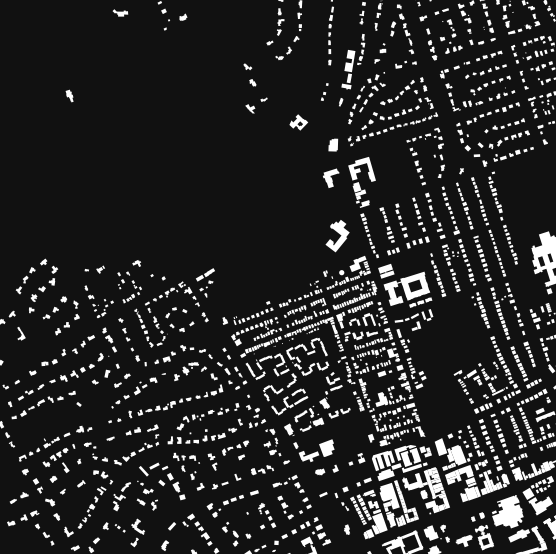

In [1]:
import osmnx as ox # pip install osmnx
import matplotlib.pyplot as plt
from IPython.display import Image

img_folder = "21_spatial_data_files"
fp = f"./{img_folder}/princeton_bldgs.png"

# (latitude, longitude) of interest
location_point = (40.3573, -74.6672)
dist=1000

# use openstreetmaps data to get all tagged features within a distance
gdf = ox.features_from_point(location_point, 
                             tags={"building": True}, 
                             dist=dist) 
# Box around our point, with UTM (Mercator) projection
bbox = ox.utils_geo.bbox_from_point(point=location_point, 
                                    dist=dist, 
                                    project_utm=True)

# Apply a map projection to the dataset
gdf_proj = ox.projection.project_gdf(gdf) 
# Plot the footprints (ground-level outlines) of the chosen features
fig, ax = ox.plot_footprints(gdf_proj,
                             bbox=bbox, 
                             color="w", 
                             filepath=fp, dpi=90, save=True,
                             show=False, close=True)

Image(fp, height=720, width=720)

## Example raster!

Rasterio reads and writes raster datasets (i.e. grid of spatial pixels).  
It uses mostly GeoTIFF format, and uses fast numpy arrays and GeoJSON.

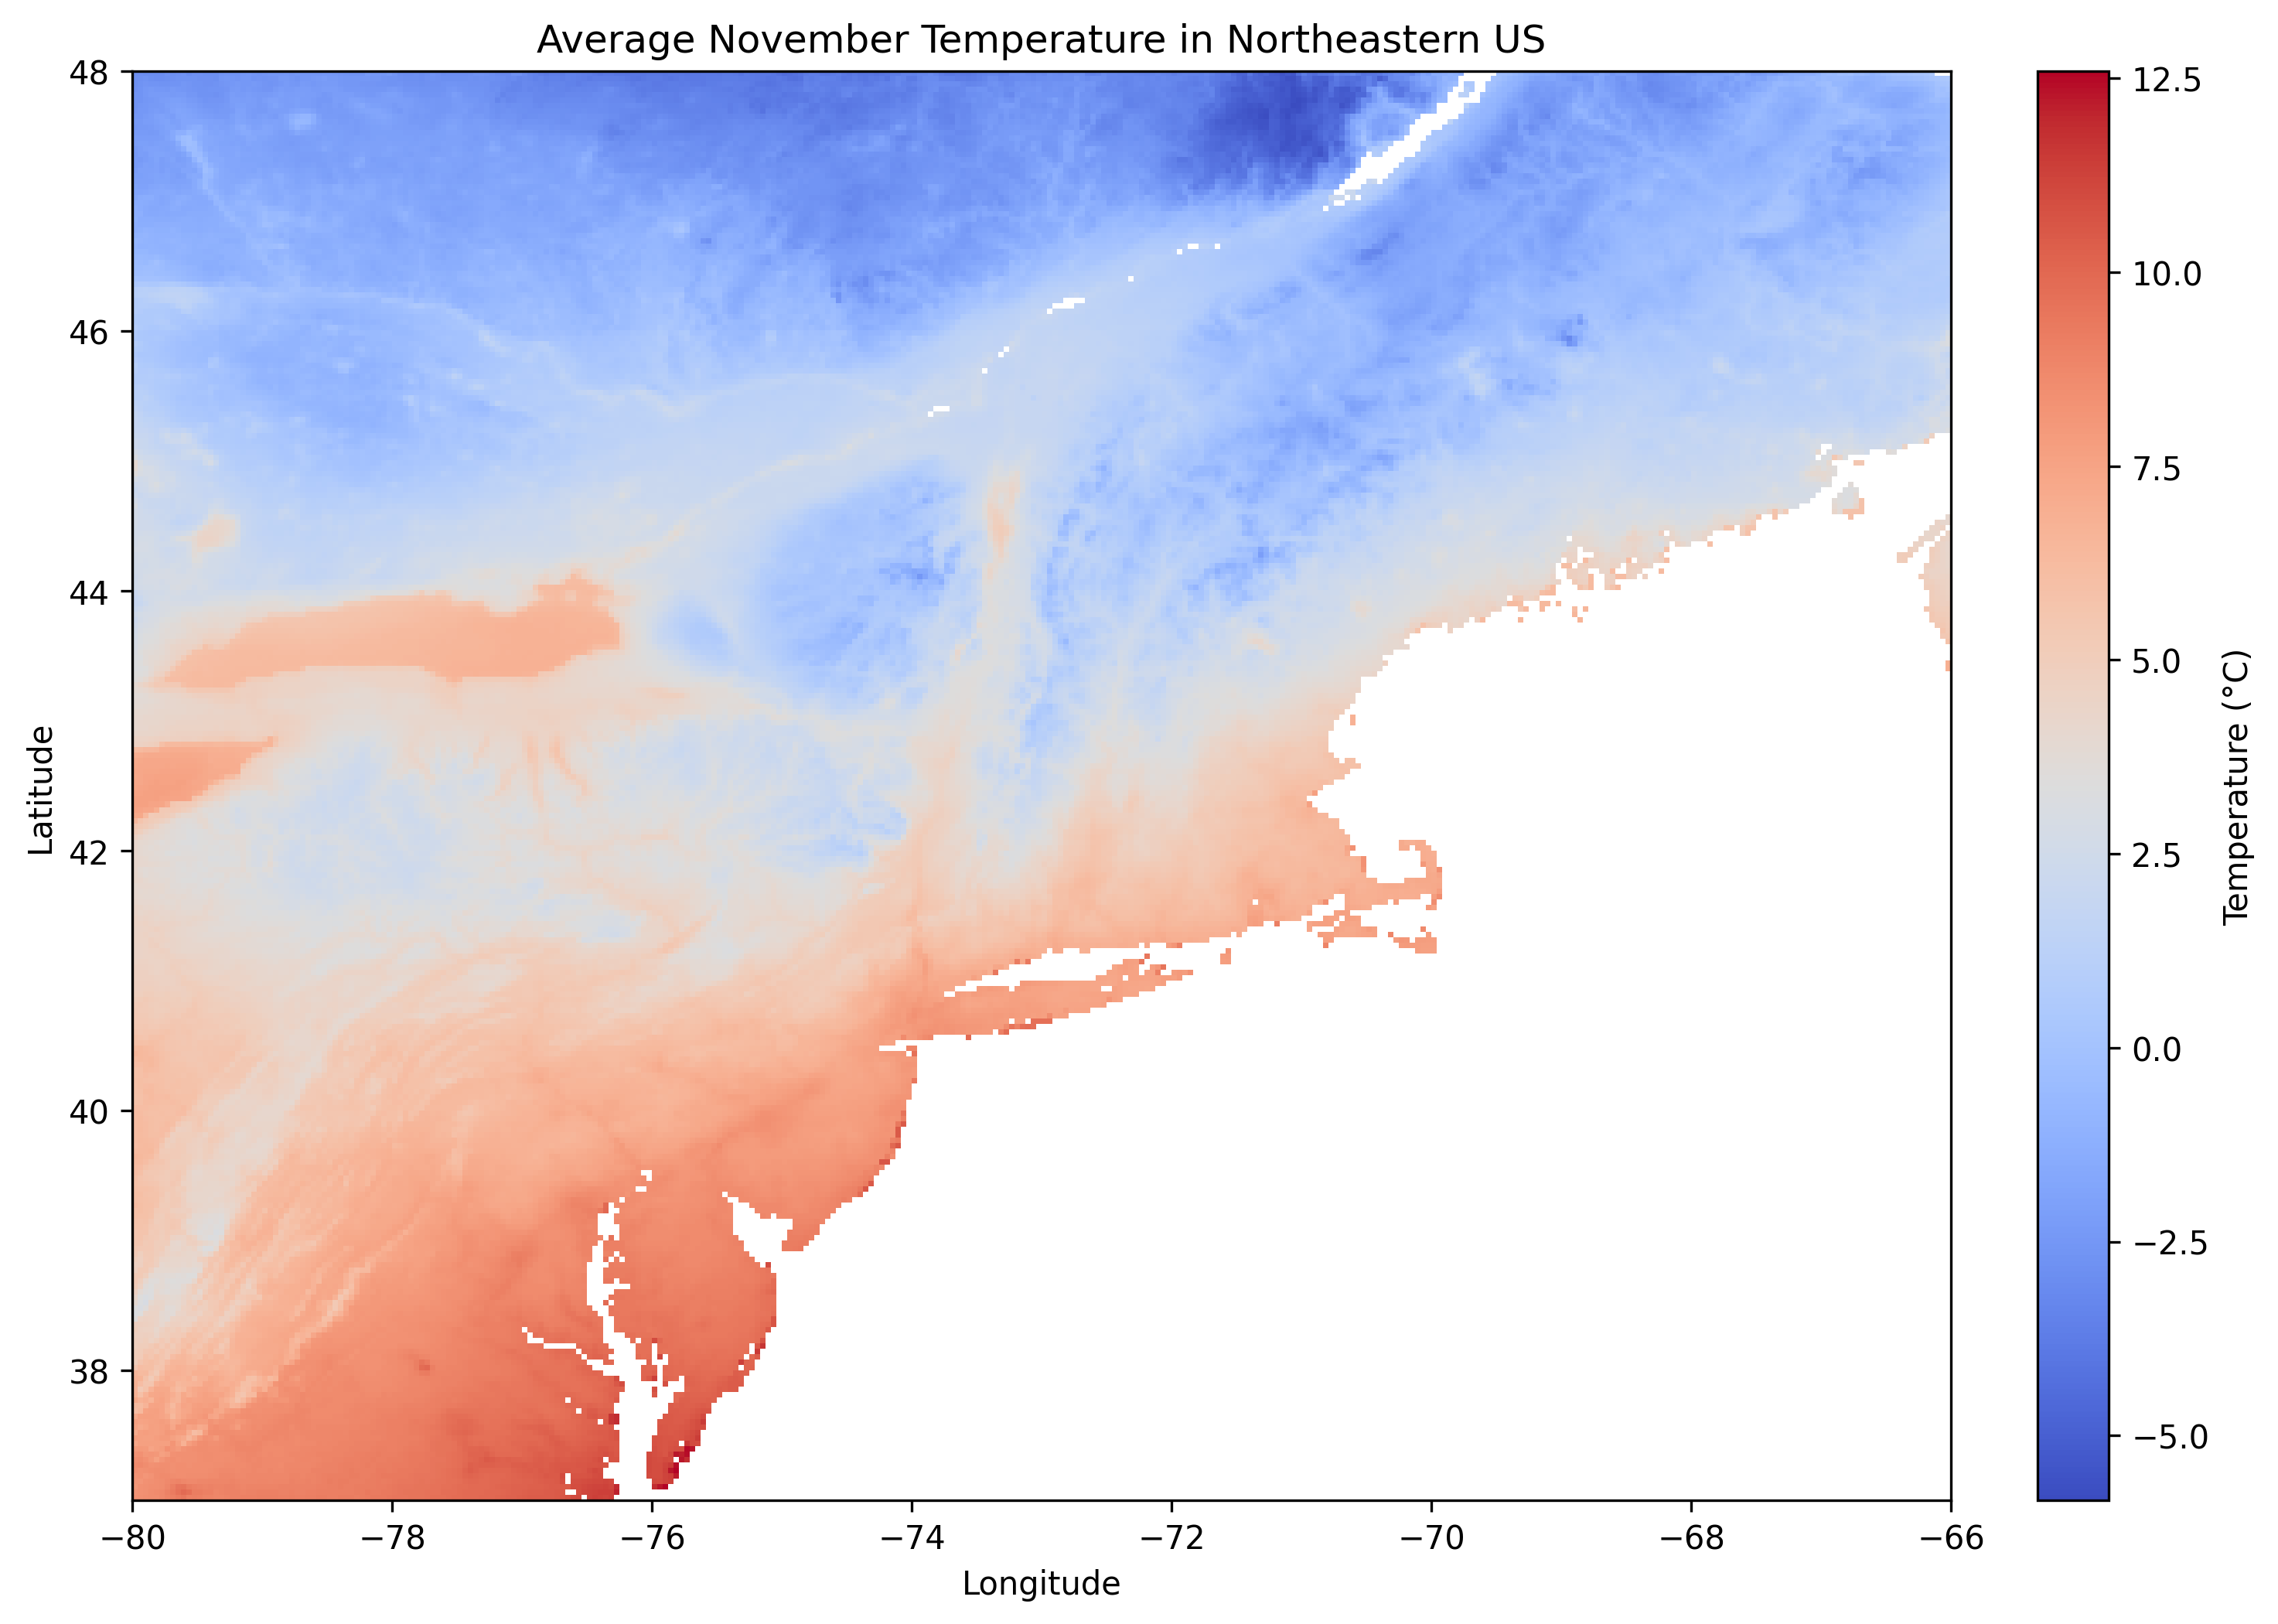

In [2]:
import rasterio as rast # pip install rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import plotting_extent

# Northeastern US bounds
min_lon, max_lon = -80, -66
min_lat, max_lat = 37, 48

# Path to the downloaded WorldClim data: see https://www.worldclim.org/data/worldclim21.html
file_path = f'{img_folder}/wc2.1_2.5m_tavg_11.tif' # 2.5 "minutes" resolution: angles on the globe define a surface

# Open the raster file
with rast.open(file_path) as dataset:
    # Calculate the pixel coordinates of the bounding box (top-left and bottom-right corners)
    # The dataset is indeed a matrix of spatial pixels
    row_min, col_min = dataset.index(min_lon, max_lat)
    row_max, col_max = dataset.index(max_lon, min_lat)

    # Read the specific window
    # arguments: (col_off, row_off, width, height)
    window = rast.windows.Window(col_min, row_min, col_max - col_min, row_max - row_min)
    temperature = dataset.read(indexes=1, window=window) # read only the first "band" of data (temperature)
    # temperature is a simple numpy 2D array now

    # Replace no-data values with NaN
    temperature = np.where(temperature < -100, np.nan, temperature)

    # Affine transformation for the window, to display the right lat/lon values on the plot axes
    transform = dataset.window_transform(window)

    # Create a high-resolution plot
    plt.figure(figsize=(12, 8), dpi=300)

    # Plotting
    img = plt.imshow(temperature, 
                     cmap='coolwarm', 
                     # important for axes labels
                     extent=plotting_extent(temperature, transform)) # (left, right, bottom, top)
    
    plt.colorbar(img, label='Temperature (°C)', fraction=0.046, pad=0.04)
    plt.title('Average November Temperature in Northeastern US')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Save the plot
    save_path = f'{img_folder}/high_res_temperature_northeast_us.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


## GBIF!

Global Biodiversity Information Facility: free and open access to biodiversity data!

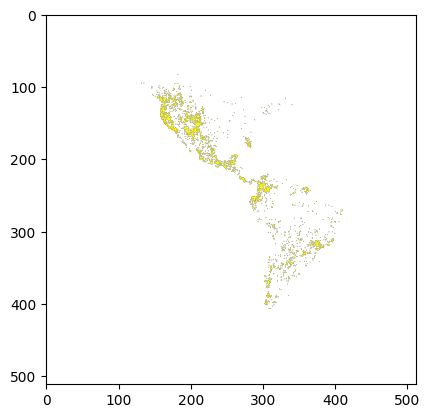

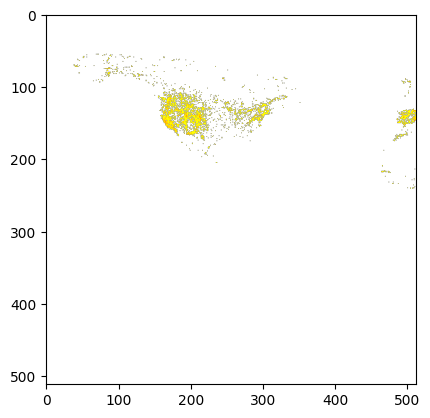

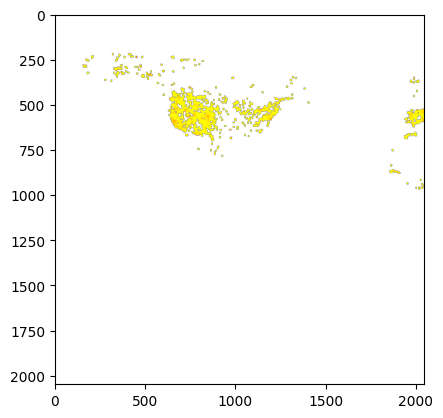

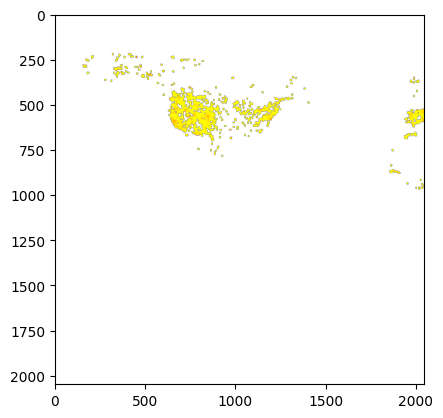

In [1]:
from pygbif import maps

# Check what taxon this taxonKey refers to on https://www.gbif.org/occurrence/search?taxon_key=2435098
out = maps.map(taxonKey = 2435098) # Puma concolor
# attributes: out.response, out.path, out.img
out.plot()

out = maps.map(taxonKey = 2480498, year = range(2008, 2012)) # Aquila audax (eaglehawk)
out.plot()

# basisOfRecord to filter data
maps.map(taxonKey = 2480498, year = 2010, 
         format='@4x.png', # image resolution: 4096px
         basisOfRecord = "HUMAN_OBSERVATION", 
         bin = "hex", hexPerTile = 500).plot()

maps.map(taxonKey = 2480498, year = 2010, 
         format='@4x.png', # image resolution: 4096px
         basisOfRecord = ["HUMAN_OBSERVATION", "LIVING_SPECIMEN"],
         bin = "hex", hexPerTile = 500).plot()


## GeoPandas!

Open source for geospatial data in python

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import requests # HTTP library for fetching web pages


In [41]:
# Fetch live "Open meteo" data for a given location
def fetch_weather_data(latitude, longitude):
    url = f"https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&current_weather=true"
    print(url)
    response = requests.get(url) # JSON format
    if response.status_code == 200: # successful fetch
        return response.json()
    else:
        return None

# Example coordinates
weather_data = fetch_weather_data(40.7128, -74.0060) # New York City coordinates
print(weather_data)


https://api.open-meteo.com/v1/forecast?latitude=40.7128&longitude=-74.006&current_weather=true
{'latitude': 40.710335, 'longitude': -73.99309, 'generationtime_ms': 0.06091594696044922, 'utc_offset_seconds': 0, 'timezone': 'GMT', 'timezone_abbreviation': 'GMT', 'elevation': 32.0, 'current_weather_units': {'time': 'iso8601', 'interval': 'seconds', 'temperature': '°C', 'windspeed': 'km/h', 'winddirection': '°', 'is_day': '', 'weathercode': 'wmo code'}, 'current_weather': {'time': '2024-11-25T20:45', 'interval': 900, 'temperature': 11.7, 'windspeed': 8.8, 'winddirection': 279, 'is_day': 1, 'weathercode': 0}}


In [42]:
from shapely.geometry import Point # shapely is for manipulation of geometric objects
import pandas as pd

# Create a DataFrame with a single row for the weather at that location
df = pd.DataFrame([weather_data])

# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=[Point(weather_data['longitude'], weather_data['latitude'])])
print(gdf)


    latitude  longitude  generationtime_ms  utc_offset_seconds timezone  \
0  40.710335  -73.99309           0.060916                   0      GMT   

  timezone_abbreviation  elevation  \
0                   GMT       32.0   

                               current_weather_units  \
0  {'time': 'iso8601', 'interval': 'seconds', 'te...   

                                     current_weather  \
0  {'time': '2024-11-25T20:45', 'interval': 900, ...   

                     geometry  
0  POINT (-73.99309 40.71034)  


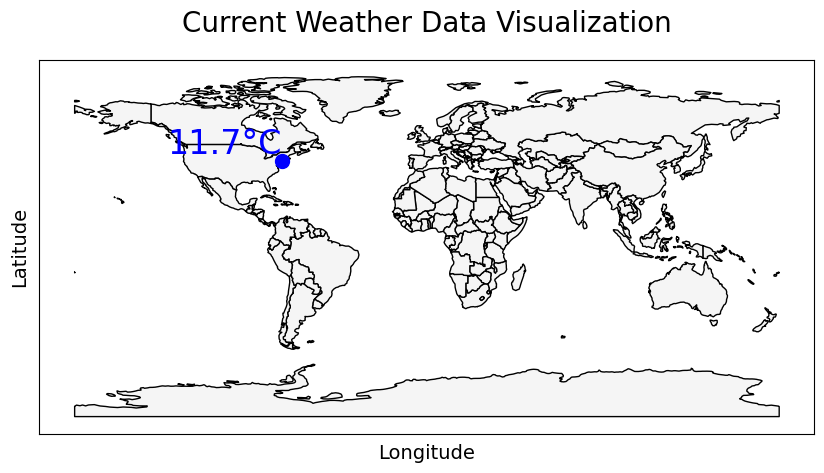

In [43]:
# Read world map for context
# wget https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip
# shp = Shapefile = most common file format for geospatial data
world = gpd.read_file(f"./{img_folder}/ne_110m_admin_0_countries.shp") 

# Create a subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the world map as the base layer
world.plot(ax=ax, color='whitesmoke', edgecolor='black')

# Plot the weather data
gdf.plot(ax=ax, color='blue', marker='o', markersize=100)

# Enhancements
for x, y, label in zip(gdf.geometry.x, 
                       gdf.geometry.y, 
                       [x['temperature'] for x in gdf['current_weather']]):
    ax.text(x, y, f'{label}°C', 
            color='blue', fontsize=24, 
            ha='right', va='bottom')

# Set plot title and labels
ax.set_title('Current Weather Data Visualization', fontdict={'fontsize': 20}, pad=20)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Remove x and y axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Add a grid
ax.grid(True, linestyle='--', color='grey', alpha=0.5)

plt.show()


## Getting Started with GeoPandas

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx # pip install contextily
import folium

# Load a GeoPandas dataset through a downloaded shape file
# wget https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_populated_places.zip
world = gpd.read_file(f"./{img_folder}/ne_110m_admin_0_countries.shp")
cities = gpd.read_file(f"./{img_folder}/ne_110m_populated_places.shp")

# Inspect the first few rows
print(world.head()) # MULTIPOLYGON for country outlines

        featurecla  scalerank  LABELRANK                   SOVEREIGNT SOV_A3  \
0  Admin-0 country          1          6                         Fiji    FJI   
1  Admin-0 country          1          3  United Republic of Tanzania    TZA   
2  Admin-0 country          1          7               Western Sahara    SAH   
3  Admin-0 country          1          2                       Canada    CAN   
4  Admin-0 country          1          2     United States of America    US1   

   ADM0_DIF  LEVEL               TYPE TLC                        ADMIN  ...  \
0         0      2  Sovereign country   1                         Fiji  ...   
1         0      2  Sovereign country   1  United Republic of Tanzania  ...   
2         0      2      Indeterminate   1               Western Sahara  ...   
3         0      2  Sovereign country   1                       Canada  ...   
4         1      2            Country   1     United States of America  ...   

      FCLASS_TR     FCLASS_ID     FCLASS_PL 

In [11]:
print(cities.head())

   SCALERANK  NATSCALE  LABELRANK           FEATURECLA          NAME NAMEPAR  \
0          8        10          3      Admin-0 capital  Vatican City    None   
1          7        20          0      Admin-0 capital    San Marino    None   
2          7        20          0      Admin-0 capital         Vaduz    None   
3          6        30          8  Admin-0 capital alt       Lobamba    None   
4          6        30          8      Admin-0 capital    Luxembourg    None   

  NAMEALT     NAMEASCII  ADM0CAP            CAPIN  ...  FCLASS_ID  FCLASS_PL  \
0    None  Vatican City        1             None  ...       None       None   
1    None    San Marino        1             None  ...       None       None   
2    None         Vaduz        1             None  ...       None       None   
3    None       Lobamba        0  Legislative and  ...       None       None   
4    None    Luxembourg        1             None  ...       None       None   

  FCLASS_GR FCLASS_IT FCLASS_NL FCLASS

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Columns: 169 entries, featurecla to geometry
dtypes: float64(6), geometry(1), int32(24), int64(1), object(137)
memory usage: 217.2+ KB
None
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 243 entries, 0 to 242
Columns: 138 entries, SCALERANK to geometry
dtypes: float64(13), geometry(1), int32(10), int64(37), object(77)
memory usage: 252.6+ KB
None


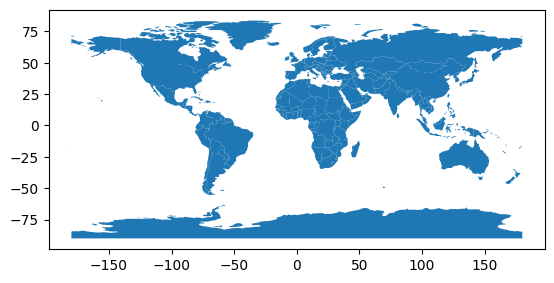

0    MULTIPOLYGON (((180 -16.06713, 180 -16.55522, ...
1    POLYGON ((33.90371 -0.95, 34.07262 -1.05982, 3...
2    POLYGON ((-8.66559 27.65643, -8.66512 27.58948...
3    MULTIPOLYGON (((-122.84 49, -122.97421 49.0025...
4    MULTIPOLYGON (((-122.84 49, -120 49, -117.0312...
Name: geometry, dtype: geometry
Index(['SCALERANK', 'NATSCALE', 'LABELRANK', 'FEATURECLA', 'NAME', 'NAMEPAR',
       'NAMEALT', 'NAMEASCII', 'ADM0CAP', 'CAPIN',
       ...
       'FCLASS_ID', 'FCLASS_PL', 'FCLASS_GR', 'FCLASS_IT', 'FCLASS_NL',
       'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA', 'FCLASS_TLC', 'geometry'],
      dtype='object', length=138)


In [12]:
# Basic info about the datasets
print(world.info())
print(cities.info())

# Plotting the world map
world.plot()
plt.show()

# Accessing the geometry
print(world.geometry.head())
print(cities.columns)

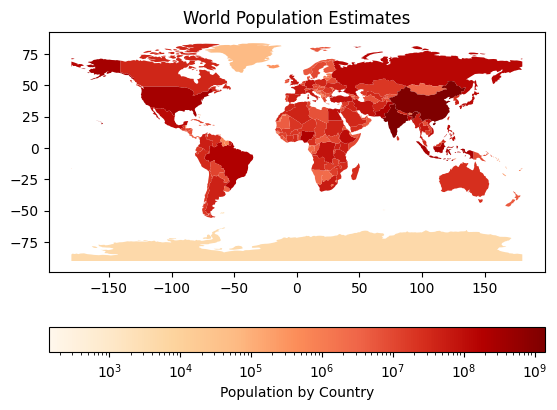

In [16]:
import matplotlib.colors as colors
# Population Estimates
fig, ax = plt.subplots(1, 1)
world.plot(column='POP_EST', 
           ax=ax, legend=True, 
           cmap='OrRd', norm=colors.LogNorm(vmin=world.POP_EST.min(), vmax=world.POP_EST.max()),
           legend_kwds={'label': "Population by Country",
                        'orientation': "horizontal"})
plt.title("World Population Estimates")
plt.show()


In [18]:
import folium # mixes Python and leaflet.js (open-source mobile-friendly interactive maps)

# Create an interactive map
m = folium.Map(location=[0, 0], zoom_start=2)

# Add points for cities
for _, city in cities.iterrows():
    folium.CircleMarker(
        location=[city.geometry.y, city.geometry.x], # geometry columns usually contains shapely.Point
        radius=5,
        popup=city['NAME'],
        color="blue",
        fill=True,
        fill_color="blue"
    ).add_to(m)

m

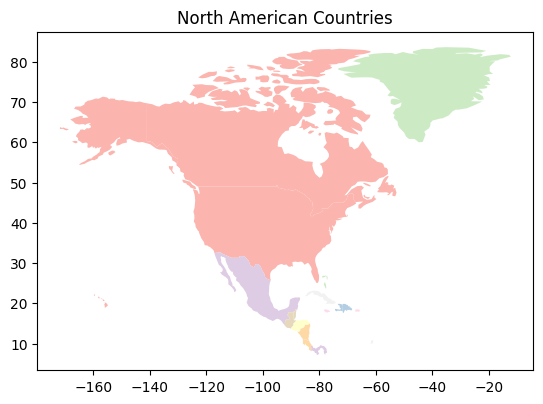

In [19]:
# Plotting specific countries
na_countries = world[world['CONTINENT'] == 'North America']
na_countries.plot(cmap='Pastel1')
plt.title("North American Countries")
plt.show()


## Spatial Joins and Geometric Operations

In [22]:
# Spatial join - cities within countries
cities_with_country = gpd.sjoin(cities, world, how="inner")
print(cities_with_country[['NAME_left', 'NAME_right']])

          NAME_left  NAME_right
0      Vatican City       Italy
1        San Marino       Italy
2             Vaduz     Austria
3           Lobamba    eSwatini
4        Luxembourg  Luxembourg
..              ...         ...
238  Rio de Janeiro      Brazil
239       São Paulo      Brazil
240          Sydney   Australia
241       Singapore    Malaysia
242       Hong Kong       China

[213 rows x 2 columns]


In [23]:
cities_with_country

SCALERANK  NATSCALE  LABELRANK_left              FEATURECLA  \
0            8        10               3         Admin-0 capital   
1            7        20               0         Admin-0 capital   
2            7        20               0         Admin-0 capital   
3            6        30               8     Admin-0 capital alt   
4            6        30               8         Admin-0 capital   
..         ...       ...             ...                     ...   
238          0       600               1         Admin-1 capital   
239          0       600               1         Admin-1 capital   
240          0       600               3         Admin-1 capital   
241          0       600               0         Admin-0 capital   
242          0       600               0  Admin-0 region capital   

          NAME_left NAMEPAR              NAMEALT       NAMEASCII  ADM0CAP  \
0      Vatican City    None                 None    Vatican City        1   
1        San Marino    None                 None      San Marino        1   
2             Vaduz    None                 None           Vaduz        1   
3           Lobamba    None                 None         Lobamba        0   
4        Luxembourg    None                 None      Luxembourg        1   
..              ...     ...                  ...             ...      ...   
238  Rio de Janeiro    None                 None  Rio de Janeiro        0   
239       São Paulo    None  Sao Paulo|Sio Paulo       Sao Paulo        0   
240          Sydney    None                 None          Sydney        0   
241       Singapore    None                 None       Singapore        1   
242       Hong Kong    None                 None       Hong Kong        0   

               CAPIN  ...  FCLASS_VN_right  FCLASS_TR_right FCLASS_ID_right  \
0               None  ...             None             None            None   
1               None  ...             None             None            None   
2               None  ...             None             None            None   
3    Legislative and  ...             None             None            None   
4               None  ...             None             None            None   
..               ...  ...              ...              ...             ...   
238             None  ...             None             None            None   
239             None  ...             None             None            None   
240             None  ...             None             None            None   
241             None  ...             None             None            None   
242             None  ...             None             None            None   

    FCLASS_PL_right FCLASS_GR_right FCLASS_IT_right FCLASS_NL_right  \
0              None            None            None            None   
1              None            None            None            None   
2              None            None            None            None   
3              None            None            None            None   
4              None            None            None            None   
..              ...             ...             ...             ...   
238            None            None            None            None   
239            None            None            None            None   
240            None            None            None            None   
241            None            None            None            None   
242            None            None            None            None   

    FCLASS_SE_right FCLASS_BD_right  FCLASS_UA_right  
0              None            None             None  
1              None            None             None  
2              None            None             None  
3              None            None             None  
4              None            None             None  
..              ...             ...              ...  
238            None            None             None  
239            None  

In [25]:
# Ensure both datasets use the same CRS (coordinate reference system)
cities = cities.to_crs(world.crs)

# Inner join - cities within countries
inner_join = gpd.sjoin(cities, world, how="inner", predicate='intersects')
print("Inner Join Result:")
print(inner_join.head())

# Left join - includes all cities, with country data where it intersects
left_join = gpd.sjoin(cities, world, how="left", predicate='intersects')
print("\nLeft Join Result:")
print(left_join.head())

Inner Join Result:
   SCALERANK  NATSCALE  LABELRANK_left           FEATURECLA     NAME_left  \
0          8        10               3      Admin-0 capital  Vatican City   
1          7        20               0      Admin-0 capital    San Marino   
2          7        20               0      Admin-0 capital         Vaduz   
3          6        30               8  Admin-0 capital alt       Lobamba   
4          6        30               8      Admin-0 capital    Luxembourg   

  NAMEPAR NAMEALT     NAMEASCII  ADM0CAP            CAPIN  ...  \
0    None    None  Vatican City        1             None  ...   
1    None    None    San Marino        1             None  ...   
2    None    None         Vaduz        1             None  ...   
3    None    None       Lobamba        0  Legislative and  ...   
4    None    None    Luxembourg        1             None  ...   

   FCLASS_VN_right  FCLASS_TR_right FCLASS_ID_right FCLASS_PL_right  \
0             None             None            Non

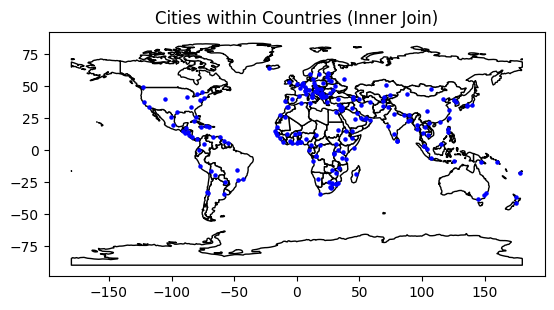

In [26]:
# Plotting the result of an inner join
base = world.plot(color='white', edgecolor='black')
inner_join.plot(ax=base, marker='o', color='blue', markersize=5)
plt.title("Cities within Countries (Inner Join)")
plt.show()

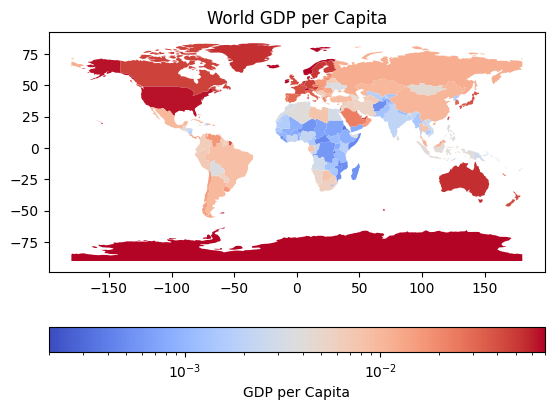

In [35]:
# GDP per capita Choropleth map
world['GDP_PER_CAP'] = world['GDP_MD'] / world['POP_EST']
fig, ax = plt.subplots(1, 1)
world.plot(column='GDP_PER_CAP', ax=ax, legend=True, 
           cmap='coolwarm', 
           legend_kwds={'label': "GDP per Capita", 'orientation': "horizontal"},
           norm=colors.LogNorm(vmin=2e-4, vmax=0.07))
plt.title("World GDP per Capita")
plt.show()

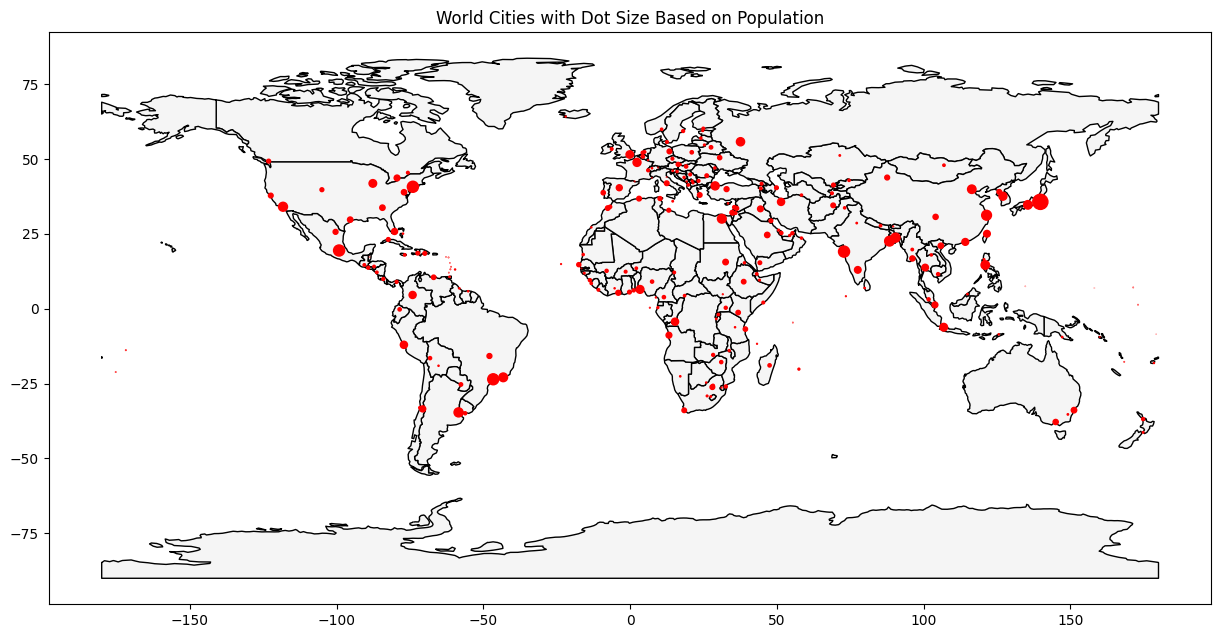

In [40]:
# Plotting cities with dot sizes based on population
fig, ax = plt.subplots(figsize=(15, 10))
world.plot(ax=ax, color='whitesmoke', edgecolor='black')
cities.plot(ax=ax, color='red', markersize=cities['POP_MAX'] / 300000)  # Adjust the denominator for size scaling
plt.title("World Cities with Dot Size Based on Population")
plt.show()